In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.io
import h5py
%matplotlib inline
from sklearn.decomposition import PCA

In [ ]:
Eigen_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/EigenWorms.mat'
Footage_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/20150814-All-PNAS2011-DataStitched .mat'

In [ ]:
class EigenData(object):
    '''Represents the original experiment data.'''

    def __init__(self):
        self._eigenworms = None

    def get_eigenworms(self, eigen_path):
        '''
        Loads the matlab files from the original experiment and parses them
        into expected numpy formats.

        Eigenworms are stored as 100 'angles' at equidistributed coordinates
        down the body.
        '''
        # Load the matlab files into numpy arrays
        eigenworms = scipy.io.loadmat(eigen_path)
        self._eigenworms = eigenworms["EigenWorms"].transpose()
        return self._eigenworms

    def get_footage(self, footage_path):
        '''
        Loads the matlab files from the original experiment and parses them
        into expected numpy formats.

        Footage is stored as coefficients with respect to the eigenworm basis.
        '''
        f = h5py.File(footage_path, 'r')
        footage = {}
        for k, v in f.items():
            if k != 'tr':
                for k2, v2 in v.items():
                    if v2.shape == (5, 33600) or v2.shape == (6, 33600):
                        footage[k2] = np.array(v2)
        return footage

    def reconstruct(self, coefficients):
        '''
        Reconstruct multiple postures from basis coefficients to angles.
        '''
        n_basis_required = coefficients.shape[0]
        print(self._eigenworms[0:n_basis_required, :].transpose().shape,
              coefficients.shape)
        return self._eigenworms[0:n_basis_required, :].transpose() @ \
            coefficients

In [ ]:
# if __name__ == "__main__":
data = EigenData()
Eigen_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/EigenWorms.mat'
Footage_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/20150814-All-PNAS2011-DataStitched .mat'
worm_data = data.get_eigenworms(Eigen_path)

footage = data.get_footage(Footage_path)
for k in footage.keys():
    print(k, footage[k].shape)
    r = data.reconstruct(footage[k])
    print('-->', r.shape)

b (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
c (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
d (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
e (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
f (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
g (6, 33600)
(100, 6) (6, 33600)
--> (100, 33600)
h (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
i (6, 33600)
(100, 6) (6, 33600)
--> (100, 33600)
j (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
k (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
l (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
m (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)


In [ ]:
letter = 'm'
print(letter, footage[letter].shape)
rb = data.reconstruct(footage[letter])
print('-->', rb.shape)

m (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)


In [ ]:
### All the data
raw_data = pd.DataFrame(rb)
raw_data = raw_data.dropna(axis=1)

### Normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
all_shape = pd.DataFrame(scaler.fit_transform(raw_data))
raw_data = all_shape.T


### using 70% data as training set, 30% as test set
training = raw_data[:int(len(raw_data)*0.8)]
testing = raw_data[len(training):]

### PCA calculation

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(all_shape)
reduced = pca.transform(all_shape)
reduced_shapes_for_testing = scaler.fit_transform(reduced)

In [ ]:
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
training_data = np.array(training.values)
testing_data = np.array(testing.values)

In [ ]:
n_steps = 25
X_train, y_train = split_sequences(training_data,50)
X_test, y_test = split_sequences(testing_data,50)
n_features = X_train.shape[2]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, Conv1D,MaxPooling1D, Flatten,TimeDistributed
import os
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 2, n_steps, n_features))
y_train = y_train.reshape(y_train.shape[0],1,y_train.shape[1])

X_test = X_test.reshape((X_test.shape[0], 2, n_steps, n_features))


In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='sigmoid'), input_shape=( None,n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(CuDNNLSTM(260,return_sequences=True))
model.add(CuDNNLSTM(260,return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(260, return_sequences=True)) 
model.add(Dropout(0.2))
model.add(CuDNNLSTM(260,return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(260, return_sequences=True))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(260, return_sequences=True))
model.add(Dropout(0.1))
model.add(Dense(n_features))
model.compile(optimizer="rmsprop", loss="mean_squared_error",metrics=['accuracy'] )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 24, 64)      12864     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 12, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 768)         0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, None, 260)         1071200   
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, None, 260)         542880    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 260)         0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, None, 260)        

In [ ]:
# fit model
import time
start = time.time()
model.fit(X_train,y_train,epochs=180, verbose=1)
end = time.time()
print(end - start)

Epoch 1/180
711/711 [==============================] - 13s 19ms/step - loss: 0.1016 - accuracy: 0.0219
Epoch 2/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0969 - accuracy: 0.0293
Epoch 3/180
711/711 [==============================] - 9s 13ms/step - loss: 0.0878 - accuracy: 0.0418
Epoch 4/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0524 - accuracy: 0.0601
Epoch 5/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0416 - accuracy: 0.0771
Epoch 6/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0370 - accuracy: 0.1154
Epoch 7/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0337 - accuracy: 0.1330
Epoch 8/180
711/711 [==============================] - 9s 13ms/step - loss: 0.0317 - accuracy: 0.1489
Epoch 9/180
711/711 [==============================] - 9s 12ms/step - loss: 0.0301 - accuracy: 0.1587
Epoch 10/180
711/711 [==============================] - 9s 12ms/step - loss: 0.02

In [ ]:
a_CNN_lstm = model.predict(X_test)
a_CNN_lstm.shape

(5649, 2, 100)

In [ ]:
result = [(a_CNN_lstm[i][0]+ a_CNN_lstm[i][1])/2 for i in range(a_CNN_lstm.shape[0])]
result = np.array(result)

In [ ]:
four = int(len(result)/4)

pre2 = result[four]
pre3 = result[2*four]
pre4 = result[3*four]
predict_list = np.array([pre2,pre3,pre4])


rea2 = y_test[four]
rea3 = y_test[2*four]
rea4 = y_test[3*four]
real_list = np.array([rea2,rea3,rea4])


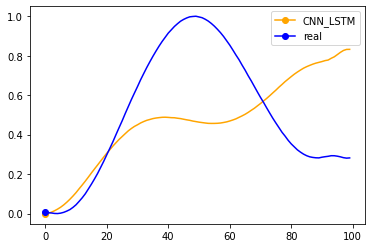

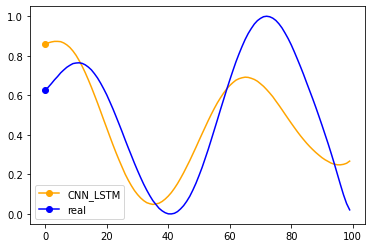

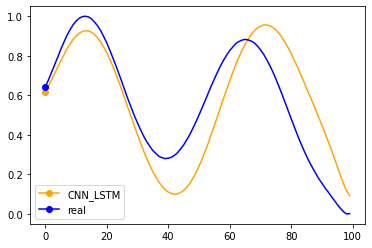

In [ ]:
for i in range(3):
  plt.plot(predict_list[i].T,'-o',c='orange',markevery=[0], label='CNN_LSTM')
  plt.plot(real_list[i].T,'-o',c='blue',markevery=[0], label='real')
  plt.legend()
  plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

all_euc = []
all_mse = []
for i in range(y_test.shape[0]):
  dist = np.linalg.norm(y_test[i]- result[i])
  all_euc.append(dist)
  all_mse.append(mean_squared_error(y_test[i], result[i]))

average_eul = np.mean(all_euc)
average_mse = np.mean(all_mse)

print(average_eul)
print(average_mse)

1.8779848899941245
0.042624126536607056
